In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
class VOCTransform:
    def __init__(self, image_transform=None, mask_transform=None):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, img, mask):
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return img, mask

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# one transform for normal images and one transform for masks
data = datasets.VOCSegmentation(
    root='../data',
    year='2012',
    image_set='train',
    download=False,
    transforms=VOCTransform(image_transform, mask_transform)
)

In [5]:
data

Dataset VOCSegmentation
    Number of datapoints: 1464
    Root location: ../data

In [6]:
train_size = int(0.8 * len(data))
test_size = int(len(data) - train_size)

train_data, test_data = random_split(data, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.enc5 = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(2)

        self.dec1 = up_block(1024, 512)
        self.dec2 = up_block(512, 256)
        self.dec3 = up_block(256, 128)
        self.dec4 = up_block(128, 64)

        self.up_conv1 = conv_block(1024, 512)
        self.up_conv2 = conv_block(512, 256)
        self.up_conv3 = conv_block(256, 128)
        self.up_conv4 = conv_block(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.enc5(self.pool(enc4))

        dec1 = self.dec1(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec1 = self.up_conv1(dec1)

        dec2 = self.dec2(dec1)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.up_conv2(dec2)

        dec3 = self.dec3(dec2)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.up_conv3(dec3)

        dec4 = self.dec4(dec3)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec4 = self.up_conv4(dec4)

        return self.out(dec4)

In [9]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch, (img, mask) in enumerate(train_loader):
        optimizer.zero_grad()
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        torch.cuda.empty_cache()
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(train_loader)


def test_epoch(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for img, mask in test_loader:
            img, mask = img.to(device), mask.to(device)
            output = model(img)
            torch.cuda.empty_cache()
            loss = criterion(output, mask)
            running_loss += loss.item()
    return running_loss / len(test_loader)


def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        test_loss = test_epoch(model, test_loader, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

In [10]:
Unet = UNet().to(device)

optimizer = torch.optim.Adam(Unet.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
train(Unet, train_loader, test_loader, loss_fn, optimizer, 5)

Epoch [1/5], Train Loss: 0.3859, Test Loss: 0.3341
Epoch [2/5], Train Loss: 0.3007, Test Loss: 0.2873
Epoch [3/5], Train Loss: 0.2714, Test Loss: 0.2573
Epoch [4/5], Train Loss: 0.2510, Test Loss: 0.2467
Epoch [5/5], Train Loss: 0.2381, Test Loss: 0.2410


In [15]:
def display_result(model: UNet, data):
    random_idx = torch.randint(low=0, high=len(data), size=(1,)).item()

    random_image: torch.Tensor = data[random_idx][0]
    random_image_label: torch.Tensor = data[random_idx][1]

    seg_image: torch.Tensor = model(random_image.unsqueeze(dim=0).to(device))
    seg_image = seg_image.squeeze().detach().cpu().numpy()
    image = random_image.permute(1, 2, 0)
    image_label = random_image_label.permute(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(12, 12))

    axes[0].imshow(image)
    axes[1].imshow(image_label)
    axes[2].imshow(seg_image)

    axes[0].set_title('real image')
    axes[0].axis('off')

    axes[1].set_title('true label')
    axes[1].axis('off')

    axes[2].set_title('predicted label')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


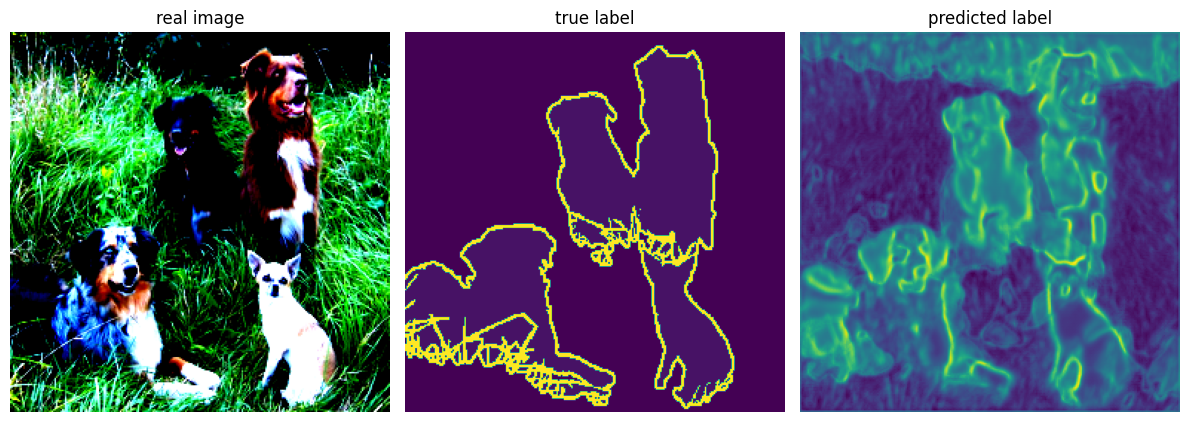

In [18]:
display_result(Unet, data)